In [1]:
import os, sys
import shutil
import json
import logging
from pathlib import Path
import multiprocessing
import argparse
import functools
from datetime import datetime
from typing import *

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from einops import rearrange

import pytorch_lightning as pl
from pytorch_lightning.strategies.ddp import DDPStrategy

from transformers import BertConfig

from foldingdiff import datasets
from foldingdiff import modelling
from foldingdiff import losses
from foldingdiff import beta_schedules
from foldingdiff import plotting
from foldingdiff import utils
from foldingdiff import custom_metrics as cm

assert torch.cuda.is_available(), "Requires CUDA to train"
# reproducibility
torch.manual_seed(6489)
# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

# Define some typing literals
ANGLES_DEFINITIONS = Literal[
    "canonical", "canonical-full-angles", "canonical-minimal-angles", "cart-coords"
]

/home/sh2748/.conda/envs/foldingdiff/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_valid_test_sets(
    dataset_key: str = "cath",
    angles_definitions: ANGLES_DEFINITIONS = "canonical-full-angles",
    max_seq_len: int = 512,
    min_seq_len: int = 0,
    seq_trim_strategy: datasets.TRIM_STRATEGIES = "leftalign",
    timesteps: int = 250,
    variance_schedule: beta_schedules.SCHEDULES = "linear",
    var_scale: float = np.pi,
    toy: Union[int, bool] = False,
    exhaustive_t: bool = False,
    syn_noiser: str = "",
    single_angle_debug: int = -1,  # Noise and return a single angle. -1 to disable, 1-3 for omega/theta/phi
    single_time_debug: bool = False,  # Noise and return a single time
    train_only: bool = False,
) -> Tuple[Dataset, Dataset, Dataset]:
    """
    Get the dataset objects to use for train/valid/test

    Note, these need to be wrapped in data loaders later
    """
    assert (
        single_angle_debug != 0
    ), f"Invalid value for single_angle_debug: {single_angle_debug}"

    clean_dset_class = {
        "canonical": datasets.CathCanonicalAnglesDataset,
        "canonical-full-angles": datasets.CathCanonicalAnglesOnlyDataset,
        "canonical-minimal-angles": datasets.CathCanonicalMinimalAnglesDataset,
        "cart-coords": datasets.CathCanonicalCoordsDataset,
    }[angles_definitions] # select one clean dataset class
    logging.info(f"Clean dataset class: {clean_dset_class}")

    splits = ["train"] if train_only else ["train", "validation", "test"]
    logging.info(f"Creating data splits: {splits}")
    clean_dsets = [
        clean_dset_class(
            pdbs=dataset_key,
            split=s,
            pad=max_seq_len,
            min_length=min_seq_len,
            trim_strategy=seq_trim_strategy,
            zero_center=False if angles_definitions == "cart-coords" else True,
            toy=toy,
        )
        for s in splits
    ]
    assert len(clean_dsets) == len(splits)
    # Set the training set mean to the validation set mean
    if len(clean_dsets) > 1 and clean_dsets[0].means is not None:
        logging.info(f"Updating valid/test mean offset to {clean_dsets[0].means}")
        for i in range(1, len(clean_dsets)):
            clean_dsets[i].means = clean_dsets[0].means

    if syn_noiser != "":
        if syn_noiser == "halfhalf":
            logging.warning("Using synthetic half-half noiser")
            dset_noiser_class = datasets.SynNoisedByPositionDataset
        else:
            raise ValueError(f"Unknown synthetic noiser {syn_noiser}")
    else:
        if single_angle_debug > 0:
            logging.warning("Using single angle noise!")
            dset_noiser_class = functools.partial(
                datasets.SingleNoisedAngleDataset, ft_idx=single_angle_debug
            )
        elif single_time_debug:
            logging.warning("Using single angle and single time noise!")
            dset_noiser_class = datasets.SingleNoisedAngleAndTimeDataset
        else:
            dset_noiser_class = datasets.NoisedAnglesDataset

    logging.info(f"Using {dset_noiser_class} for noise")
    noised_dsets = [
        dset_noiser_class(
            dset=ds,
            dset_key="coords" if angles_definitions == "cart-coords" else "angles",
            timesteps=timesteps,
            exhaustive_t=(i != 0) and exhaustive_t,
            beta_schedule=variance_schedule,
            nonangular_variance=1.0,
            angular_variance=var_scale,
        )
        for i, ds in enumerate(clean_dsets)
    ]
    for dsname, ds in zip(splits, noised_dsets):
        logging.info(f"{dsname}: {ds}")

    # Pad with None values
    if len(noised_dsets) < 3:
        noised_dsets = noised_dsets + [None] * int(3 - len(noised_dsets))
    assert len(noised_dsets) == 3

    return tuple(noised_dsets)


## Clean Datasets

In [3]:
angles_definitions = "canonical-full-angles"
dataset_key = "cath"
max_seq_len = 128
min_seq_len = 0
seq_trim_strategy = "leftalign"
toy = False
train_only = False

clean_dset_class = {
        "canonical": datasets.CathCanonicalAnglesDataset,
        "canonical-full-angles": datasets.CathCanonicalAnglesOnlyDataset,
        "canonical-minimal-angles": datasets.CathCanonicalMinimalAnglesDataset,
        "cart-coords": datasets.CathCanonicalCoordsDataset,
}[angles_definitions] # select one clean dataset class
logging.info(f"Clean dataset class: {clean_dset_class}")

splits = ["train"] if train_only else ["train", "validation", "test"]
logging.info(f"Creating data splits: {splits}")
clean_dsets = [
    clean_dset_class(
        pdbs=dataset_key,
        split=s,
        pad=max_seq_len,
        min_length=min_seq_len,
        trim_strategy=seq_trim_strategy,
        zero_center=False if angles_definitions == "cart-coords" else True,
        toy=toy,
    )
    for s in splits
]
train_dataset, valid_dataset, test_dataset = clean_dsets

In [4]:
len(train_dataset)

24744

In [6]:
data_list = [train_dataset[i] for i in range(len(train_dataset))]

In [7]:
import pandas as pd
df = pd.DataFrame(data_list)

In [8]:
df['lengths'] = df['lengths'].apply(lambda x: x.item())

In [9]:
df.head()

,angles,coords,attn_mask,position_ids,lengths
0,"[[tensor(0.), tensor(2.2145), tensor(0.0518), ...","[[tensor(22.8600), tensor(9.1630), tensor(-16....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
1,"[[tensor(0.), tensor(2.0380), tensor(-0.0854),...","[[tensor(37.8040), tensor(18.1140), tensor(74....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
2,"[[tensor(0.), tensor(-0.4563), tensor(-0.0311)...","[[tensor(90.2120), tensor(-6.4020), tensor(28....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
3,"[[tensor(0.), tensor(1.6385), tensor(0.0284), ...","[[tensor(15.7680), tensor(12.6430), tensor(0.1...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",60
4,"[[tensor(0.), tensor(-1.5024), tensor(0.0227),...","[[tensor(31.5080), tensor(33.7230), tensor(66....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",56


In [10]:
df['lengths'].value_counts()

128    12729
106      193
102      191
101      190
91       185
       ...  
15         4
16         4
14         2
9          2
11         1
Name: lengths, Length: 118, dtype: int64

In [11]:
df_sorted = df.sort_values(by='lengths', ascending=False)
df_sorted.head()

,angles,coords,attn_mask,position_ids,lengths
0,"[[tensor(0.), tensor(2.2145), tensor(0.0518), ...","[[tensor(22.8600), tensor(9.1630), tensor(-16....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13770,"[[tensor(0.), tensor(2.4728), tensor(0.0865), ...","[[tensor(81.3980), tensor(60.9990), tensor(17....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13772,"[[tensor(0.), tensor(0.0685), tensor(-0.0457),...","[[tensor(4.8600), tensor(33.1790), tensor(30.4...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13773,"[[tensor(0.), tensor(-0.7958), tensor(0.0570),...","[[tensor(-8.3990), tensor(-51.4170), tensor(10...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13774,"[[tensor(0.), tensor(2.2847), tensor(0.0195), ...","[[tensor(63.0130), tensor(37.3180), tensor(-3....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128


In [12]:
subset_df = df_sorted[df_sorted['lengths'] == 128]
subset_df.head()

,angles,coords,attn_mask,position_ids,lengths
0,"[[tensor(0.), tensor(2.2145), tensor(0.0518), ...","[[tensor(22.8600), tensor(9.1630), tensor(-16....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13770,"[[tensor(0.), tensor(2.4728), tensor(0.0865), ...","[[tensor(81.3980), tensor(60.9990), tensor(17....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13772,"[[tensor(0.), tensor(0.0685), tensor(-0.0457),...","[[tensor(4.8600), tensor(33.1790), tensor(30.4...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13773,"[[tensor(0.), tensor(-0.7958), tensor(0.0570),...","[[tensor(-8.3990), tensor(-51.4170), tensor(10...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
13774,"[[tensor(0.), tensor(2.2847), tensor(0.0195), ...","[[tensor(63.0130), tensor(37.3180), tensor(-3....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128


In [13]:
# filtered_df = df[(df['lengths'] >= 60) & (df['lengths'] <= 128)]

filtered_df = df[(df['lengths'] == 128)]
# Count the number of rows in the filtered DataFrame
count = len(filtered_df)
count

12729

In [14]:
filtered_df.head()

,angles,coords,attn_mask,position_ids,lengths
0,"[[tensor(0.), tensor(2.2145), tensor(0.0518), ...","[[tensor(22.8600), tensor(9.1630), tensor(-16....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
1,"[[tensor(0.), tensor(2.0380), tensor(-0.0854),...","[[tensor(37.8040), tensor(18.1140), tensor(74....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
2,"[[tensor(0.), tensor(-0.4563), tensor(-0.0311)...","[[tensor(90.2120), tensor(-6.4020), tensor(28....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
5,"[[tensor(0.), tensor(3.0645), tensor(0.1065), ...","[[tensor(32.4950), tensor(16.9030), tensor(16....","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128
6,"[[tensor(0.), tensor(-3.0076), tensor(-0.0180)...","[[tensor(14.1050), tensor(4.7190), tensor(40.3...","[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[tensor(0), tensor(1), tensor(2), tensor(3), t...",128


In [18]:
ts = torch.load('protein_angles_60_128.pt')
ts.shape

/tmp/tmp.iD1eevmCgx/ipykernel_1448233/2656042750.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ts = torch.load('protein_angles_60_128.pt')


torch.Size([22806, 128, 6])

In [23]:
torch.save(filtered_df['angles'][0].unsqueeze(0), 'protein_angles_1sanity_128.pt')

In [28]:
torch.save(torch.stack(filtered_df['angles'].head(100).tolist()),  'protein_angles_100sanity_128.pt')

In [2]:
# Define a PyTorch Dataset class
class MyDataset(Dataset):
    def __init__(self, dataframe=None, data_path=None):
        if data_path is not None:
            print(f"Initializing from a data path: {data_path}")
            self.data = torch.load(data_path)
        elif data_path is None and dataframe is not None:
            print("Initializing from a dataframe.")
            self.data = torch.stack(dataframe['angles'].tolist())
        else:
            raise Exception("Dataframe and data path are both None!")
        
         
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Initialize the dataset with the DataFrame
dataset = MyDataset(data_path="protein_angles_60_128.pt")
dataloader = DataLoader(
    dataset,
    batch_size=32,       # Number of samples per batch
    shuffle=True,        # Shuffle the data at every epoch
    num_workers=4        # Number of subprocesses to use for data loading
)

Initializing from a data path: protein_angles_60_128.pt


/tmp/tmp.qSyGzaLx8N/ipykernel_3758058/2395865528.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(data_path)
/home/sh2748/.conda/envs/foldingdiff/l

In [4]:
batch = next(iter(dataloader))
batch.shape

torch.Size([32, 128, 6])

In [5]:
from IntegralFlowMatching.integral_flow_matching import IntegralFlowMatcher
IFM = IntegralFlowMatcher(sigma=0.1, same_time=True, time_interp=True, noise_on_x0=True, noise_on_x1=True)

Noise is not varying.


In [10]:
x0 = torch.randn_like(batch)
x0.shape

torch.Size([32, 128, 6])

In [32]:
t, xt, mu_t = IFM.sample_conditional_flow(rearrange(x0, 'b s d -> b (s d)').to("cuda"), rearrange(batch, 'b s d -> b (s d)').to("cuda"), 16,  device = "cuda")
xt = rearrange(xt, 'b t (s d) -> b t s d', s=x0.shape[1])
mu_t = rearrange(mu_t, 'b t (s d) -> b t s d', s=x0.shape[1])
print(f"Shapes:{xt.shape}, {mu_t.shape}")
print(f"Any out of range values in xt: {((xt < -np.pi) | (xt > np.pi)).any().item()}")
print(f"Any out of range values in mu_t: {((mu_t < -np.pi) | (mu_t > np.pi)).any().item()}")

Shapes:torch.Size([32, 16, 128, 6]), torch.Size([32, 16, 128, 6])
Any out of range values in xt: True
Any out of range values in mu_t: True


In [28]:
def modulo_with_wrapped_range(
    vals, range_min: float = -np.pi, range_max: float = np.pi
):
    """
    Modulo with wrapped range -- capable of handing a range with a negative min

    modulo_with_wrapped_range(3, -2, 2)
    -1
    """
    assert range_min <= 0.0
    assert range_min < range_max

    # Modulo after we shift values
    top_end = range_max - range_min
    # Shift the values to be in the range [0, top_end)
    vals_shifted = vals - range_min
    # Perform modulo
    vals_shifted_mod = vals_shifted % top_end
    # Shift back down
    retval = vals_shifted_mod + range_min

    # Checks
    # print("Mod return", vals, " --> ", retval)
    # if isinstance(retval, torch.Tensor):
    #     notnan_idx = ~torch.isnan(retval)
    #     assert torch.all(retval[notnan_idx] >= range_min)
    #     assert torch.all(retval[notnan_idx] < range_max)
    # else:
    #     assert (
    #         np.nanmin(retval) >= range_min
    #     ), f"Illegal value: {np.nanmin(retval)} < {range_min}"
    #     assert (
    #         np.nanmax(retval) <= range_max
    #     ), f"Illegal value: {np.nanmax(retval)} > {range_max}"
    return retval

In [33]:
xt = modulo_with_wrapped_range(xt)
mu_t = modulo_with_wrapped_range(mu_t)
print(f"Shapes:{xt.shape}, {mu_t.shape}")
print(f"Any out of range values in xt: {((xt < -np.pi) | (xt > np.pi)).any().item()}")
print(f"Any out of range values in mu_t: {((mu_t < -np.pi) | (mu_t > np.pi)).any().item()}")

Shapes:torch.Size([32, 16, 128, 6]), torch.Size([32, 16, 128, 6])
Any out of range values in xt: False
Any out of range values in mu_t: False


In [1]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


NameError: name 'nn' is not defined

In [ ]:
class ProteinAngleFlowModel(nn.Module):
    def __init__(self, 
    ):
        super().__init__()
        # Encoder (GPT2)
        self.proj_in = SimpleMLP(input)
        self.proj_out = 
        self.llm_model = 
        self.vae_decoder = 

    def forward(self,
    ):

In [7]:
angles.reshape(-1, 6)

tensor([[ 0.0000,  2.2145,  0.0518,  0.0390, -0.0134,  0.0068],
        [ 0.1364, -0.5284, -0.0071, -0.0154,  0.0180, -0.0256],
        [ 0.2117,  2.3975, -0.0455, -0.0371,  0.0043, -0.0101],
        ...,
        [ 0.1442, -0.6894,  0.0292, -0.0181, -0.0317, -0.0042],
        [-1.4266,  2.5585, -0.2056, -0.0346,  0.0207, -0.0707],
        [-0.9670,  2.7036, -0.0675, -0.0445,  0.0050, -0.0678]])

/tmp/tmp.iD1eevmCgx/ipykernel_1469539/2484385062.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  angles = torch.load("protein_angles_100sanity_128.pt")


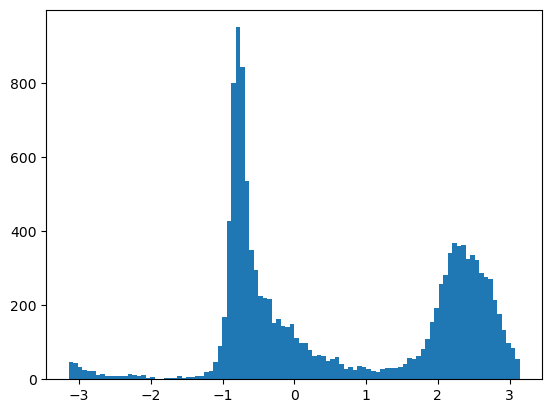

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
angles = torch.load("protein_angles_100sanity_128.pt")
_ = plt.hist(angles.reshape(-1, 6)[:,1], bins=100, range=(-np.pi, np.pi))

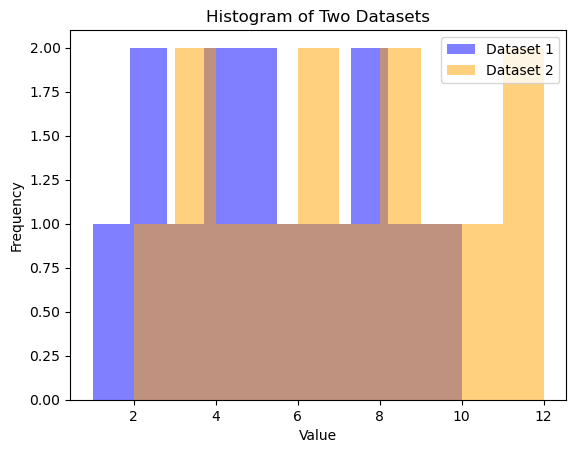

In [26]:
import matplotlib.pyplot as plt

# Sample data for two histograms
data1 = [1, 2, 2, 3, 4, 4, 5, 5, 6, 7, 8, 8, 9, 10]
data2 = [2, 3, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12]

# Plot histograms
plt.hist(data1, bins=10, alpha=0.5, label='Dataset 1', color='blue')
plt.hist(data2, bins=10, alpha=0.5, label='Dataset 2', color='orange')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Two Datasets')
plt.legend()

# Show plot
plt.show()
